## Import

In [1]:
from ipywidgets import *

import pickle
import cortex

import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib as mpl
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

from cycler import cycler
from scipy.stats import zscore, pearsonr, kendalltau, spearmanr, ttest_rel, ttest_1samp, ttest_ind
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter1d, convolve1d
from statsmodels.stats.multitest import fdrcorrection
from sklearn.decomposition import PCA

from nltools.stats import fdr, fisher_r_to_z
from sklearn.metrics import jaccard_score
from nltools.data import Brain_Data, Design_Matrix

import warnings
warnings.filterwarnings(action='ignore')

np.set_printoptions(suppress=True)

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

/home/dasom/anaconda3/envs/p38/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

exclude_short_movie = np.load('/home/dasom/State_dynamics/results/exclude_short_movie.npy')

rest_tr_ep1 = np.load('/home/dasom/State_dynamics/results/rest_tr_ep1.npy')
rest_tr_ep2 = np.load('/home/dasom/State_dynamics/results/rest_tr_ep2.npy')
rest_tr_ep3 = np.load('/home/dasom/State_dynamics/results/rest_tr_ep3.npy')

rest_total = rest_tr_ep1.shape[0] + rest_tr_ep2.shape[0] + rest_tr_ep3.shape[0]
rest_tr = np.hstack([rest_tr_ep1, rest_tr_ep2+996, rest_tr_ep3+996+958])
print(f'{rest_tr_ep1.shape[0]} + {rest_tr_ep2.shape[0]} + {rest_tr_ep3.shape[0]} = {rest_total}')

986 + 914 + 666 = 2566


## Novelty and Memorability measurements

#### Memorability

In [3]:
Memorability_score_total = np.load('/home/dasom/State_dynamics/results/Memorability_score_total.npy')
Memorability_score = np.load('/home/dasom/State_dynamics/results/Memorability_score.npy')
Memorability_score_binary = np.load('/home/dasom/State_dynamics/results/Memorability_score_binary.npy')
memorability = np.mean(Memorability_score, axis=0)

recall_sim = np.zeros((24,24))
for s1 in range(24):
    for s2 in range(24):
        # recall_sim[s1,s2] = pearsonr(Memorability_score[s1],Memorability_score[s2])[0]
        recall_sim[s1,s2] = jaccard_score(Memorability_score_binary[s1],Memorability_score_binary[s2])

([], [])

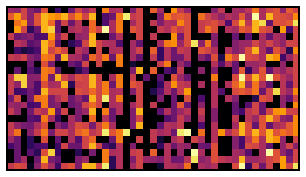

In [4]:
plt.figure(figsize = [6,3])
plt.imshow(Memorability_score, cmap = 'inferno', vmin = 0, vmax = 0.6)
plt.xticks([])
plt.yticks([])
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Recall_performance.png', dpi=300, bbox_inches = "tight")

#### Novelty

In [4]:
cooccur_sim = np.load('/home/dasom/State_dynamics/results/cooccur_similarity.npy')

nove_cooccur_1 = np.where(cooccur_sim >= np.percentile(cooccur_sim,200/3))[0]
nove_cooccur_2 = np.where((cooccur_sim >= np.percentile(cooccur_sim,100/3)) & (cooccur_sim < np.percentile(cooccur_sim,200/3)))[0]
nove_cooccur_3 = np.where(cooccur_sim < np.percentile(cooccur_sim,100/3))[0]

valence_sim = np.load('/home/dasom/State_dynamics/results/valence_similarity.npy')

nove_valence_1 = np.where(valence_sim >= np.percentile(valence_sim,200/3))[0]
nove_valence_2 = np.where((valence_sim >= np.percentile(valence_sim,100/3)) & (valence_sim < np.percentile(valence_sim,200/3)))[0]
nove_valence_3 = np.where(valence_sim < np.percentile(valence_sim,100/3))[0]

### Just valence
valence = np.load('/home/dasom/State_dynamics/results/valence_just.npy')

In [ ]:
x = np.sort(zscore(cooccur_sim))
y = zscore(valence_sim)[np.argsort(zscore(cooccur_sim))]
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) + x**2 / np.sum(x**2))

fig, ax = plt.subplots(figsize = [5,5])
ax.plot(x, y_est, '-', color = 'black', linewidth = 3)
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2, color = 'grey')
ax.scatter(x, y, s = 50, color='red', edgecolor = 'black')

plt.xlim([-2,2])
plt.ylim([-2.3,1.3])
plt.xticks([-1,0,1])
plt.yticks([-2,-1,0,1])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Relationship_btw_cooccur_valence.png', dpi=300, bbox_inches = "tight")

#### Relationship novelty and memorability

In [ ]:
np.random.seed(2024)
fig = plt.figure(figsize = [10,5])
axs = fig.add_subplot(1,2,1)
subj_memory = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_cooccur_1, nove_cooccur_2, nove_cooccur_3]])
violin_parts = axs.violinplot(subj_memory.T, np.arange(3), showmeans=False, showmedians=False, showextrema=False, widths = 0.5)
for vp in violin_parts['bodies']:
    vp.set_facecolor('#FF0000')  # aa0000 FF00FF 00FFFF
    vp.set_edgecolor('#000000')
    vp.set_alpha(0.5)

for c in range(3):
    plt.scatter(np.random.normal(loc = c, scale = 0.02, size = 24), subj_memory[c], color = 'grey')
    plt.hlines(np.mean(subj_memory[c]), c-0.1, c+0.1, zorder = 1, color = 'k')

axs.set_xticks([0,1,2])
axs.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
axs.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5])
axs.set_xlim([-0.5,2.5])
axs.set_ylim([0, 0.5])

axs = fig.add_subplot(1,2,2)
subj_memory = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_valence_1, nove_valence_2, nove_valence_3]])
violin_parts = axs.violinplot(subj_memory.T, np.arange(3), showmeans=False, showmedians=False, showextrema=False, widths = 0.5)
for vp in violin_parts['bodies']:
    vp.set_facecolor('#9C27B0')  # aa0000 FF00FF 00FFFF
    vp.set_edgecolor('#000000')
    vp.set_alpha(0.5)

for c in range(3):
    plt.scatter(np.random.normal(loc = c, scale = 0.02, size = 24), subj_memory[c], color = 'grey')
    plt.hlines(np.mean(subj_memory[c]), c-0.1, c+0.1, zorder = 1, color = 'k')

axs.set_xticks([0,1,2])
axs.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
axs.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5])
axs.set_xlim([-0.5,2.5])
axs.set_ylim([0, 0.5])
fig.tight_layout()
fig.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Relationship_btw_novelty_memory.png', dpi=300, bbox_inches = "tight")

In [ ]:
import numpy as np 
import pandas as pd 
from statsmodels.stats.anova import AnovaRM 

# score_mean = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_cooccur_1, nove_cooccur_2, nove_cooccur_3]])
score_mean = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_valence_1, nove_valence_2, nove_valence_3]])
# Create the data 
dataframe = pd.DataFrame({'Sub': np.tile(np.arange(24),3),
                          'Cond': np.repeat([1, 2, 3], 24), 
                          'Recall' : np.hstack([score_mean[i] for i in range(3)])}) 
  
# Conduct the repeated measures ANOVA 
print(AnovaRM(data=dataframe, depvar='Recall', subject='Sub', within=['Cond']).fit()) 

In [ ]:
# score_mean = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_cooccur_1, nove_cooccur_2, nove_cooccur_3]])
score_mean = np.array([np.mean(Memorability_score[:,i], axis=1) for i in [nove_valence_1, nove_valence_2, nove_valence_3]])
ttest_rel(score_mean[0], score_mean[1])

#### Movie event onset and offset

In [5]:
overlap_start = np.load('/home/dasom/State_dynamics/results/movie_event_start_idx.npy')
overlap_end = np.load('/home/dasom/State_dynamics/results/movie_event_boundary_idx.npy')

#### Recall onset and offset

In [6]:
event_start_tot = np.load('/home/dasom/State_dynamics/results/Recall_event_onset.npy', allow_pickle=True)
event_end_tot = np.load('/home/dasom/State_dynamics/results/Recall_event_offset.npy', allow_pickle=True)
event_idx = np.load('/home/dasom/State_dynamics/results/Recall_event_idx.npy', allow_pickle=True)

In [38]:
# np.load('/home/dasom/State_dynamics/results/Memorability_score_binary.npy')
np.save('/home/dasom/State_dynamics/results/Recall_event_onset.npy', event_start_tot)

## Brain data

In [8]:
with open('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/SM_DATA/social_movie1/results/fMRI_data/movie_data_ex2_sc_sm.pickle', 'rb') as f:
    movie_data = pickle.load(f)
    
# with open('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/SM_DATA/social_movie1/results/fMRI_data/recall_data_ex2_sc_sm.pickle', 'rb') as f:
#     recall_data_concat = pickle.load(f)

In [9]:
brain_mask = nib.load(f'/home/dasom/SM_DATA/mri_data/mask_files/MNI152NLin2009cAsym_3mm_mask.nii.gz').get_fdata()
mask = nib.load('/home/dasom/SM_DATA/mri_data/mask_files/BNA_3mm_atlas.nii.gz').get_fdata()

roi_mask1 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [215,216,217,218]])
pca_canonical = PCA(n_components=20)
data = np.mean(movie_data[:,roi_mask1][:,:,rest_tr], axis=0)
data_hipp = pca_canonical.fit(data.T)

In [10]:
# movie viewing

window_length = 21

roi_mask1 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [215,216,217,218]]) # HIPP
roi_mask2 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [111,112,119,120]]) # PHC
roi_mask3 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [115,116]]) # EC
roi_mask4 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [117,118]]) # PRC
roi_mask5 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [75,76,79,80]]) # STG
roi_mask6 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [87,88,121,122]]) # STS
roi_mask7 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [143,144]]) # TPJ
roi_mask8 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [153,154,175,176]]) # PMC
roi_mask9 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [13,14]]) # DMPFC
roi_mask10 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [41,42]]) # VMPFC
roi_mask11 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [189,190,191,192,193,194]]) # VC
roi_mask12 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [71,72]]) # AC
roi_mask13 = np.hstack([np.where(mask[brain_mask > 0] == r)[0] for r in [179,187,188]]) # ACC

patterns = []
for rm in [roi_mask1,roi_mask2,roi_mask3,roi_mask4,roi_mask5,roi_mask6,roi_mask7,roi_mask8,roi_mask9,roi_mask10,roi_mask11,roi_mask12]:
    pattern = []
    for s in range(movie_data.shape[0]):
        movie_data_sub = movie_data[s, rm]
        ev_pattern = []
        for ev in overlap_end[exclude_short_movie[1:]]:
            ev_pattern.append(movie_data_sub[:,ev-6:ev+15])
        pattern.append(ev_pattern)
    patterns.append(np.array(pattern))
    # patterns.append(gaussian_filter1d(pattern, sigma = 2, axis=-1)) # For visualization

In [ ]:
# narrative recall
window_length = 21 # 18 for end

patterns_recall = []
for rm in [roi_mask1,roi_mask2,roi_mask3,roi_mask4,roi_mask5,roi_mask6,roi_mask7,roi_mask8,roi_mask9,roi_mask10,roi_mask11,roi_mask12,roi_mask13,roi_mask14]:
    pattern = []
    for s in range(len(recall_data_concat)):
        recall_data_sub = recall_data_concat[s][rm]
        ev_pattern = []
        for ev in event_start_tot[s]:
            ev_pattern.append(recall_data_sub[:,ev-6:ev+15])
        pattern.append(np.array(ev_pattern))
    patterns_recall.append(pattern)
    # patterns.append(gaussian_filter1d(pattern, sigma = 2, axis=-1)) # For visualization

## Subspace analysis

#### 1. Linear regression

##### Novelty & Memory

In [35]:
# each subject
which_cognition = 'memory'

np.random.seed(2023)

repetition = 1000
beta_true = []
beta_perm = []
for data_pattern in patterns:
    beta_tot_true = []
    beta_tot_perm = []
    for repeat in range(repetition + 1):
        if repeat == 0:
            if which_cognition == 'novelty':
                conds = np.array([np.intersect1d(nove_cooccur_1, nove_valence_1), np.intersect1d(nove_cooccur_1, nove_valence_2), np.intersect1d(nove_cooccur_1, nove_valence_3),
                                  np.intersect1d(nove_cooccur_2, nove_valence_1), np.intersect1d(nove_cooccur_2, nove_valence_2), np.intersect1d(nove_cooccur_2, nove_valence_3),
                                  np.intersect1d(nove_cooccur_3, nove_valence_1), np.intersect1d(nove_cooccur_3, nove_valence_2), np.intersect1d(nove_cooccur_3, nove_valence_3)])
            elif which_cognition == 'valence':
                conds = np.array(np.array_split(np.argsort(valence), 6))
            elif which_cognition == 'memory':
                conds = np.array_split(np.argsort(-memorability), 9) # from low to high
            
            conds_regressor = []
            for cd in conds:
                cr = np.zeros(43)
                cr[cd] = 1
                conds_regressor.append(cr)

            FIR_tot = []
            for s in range(movie_data.shape[0]):
                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot.append(beta)
            FIR_tot = np.array(FIR_tot)

            for s in range(movie_data.shape[0]):
                if which_cognition == 'novelty':
                    F = np.array([[-1,-1,-1,0,0,0,1,1,1],
                                  [-1,0,1,-1,0,1,-1,0,1],
                                  [1,1,1,1,1,1,1,1,1]]) 
                elif which_cognition == 'valence':
                    F = np.array([[-5,-3,-1,1,3,5],
                                  [1,1,1,1,1,1]])  
                elif which_cognition == 'memory':   
                    F = np.array([[np.mean(memorability[ev]) - np.mean(memorability) for ev in conds],
                                  [1,1,1,1,1,1,1,1,1]])             
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[s][t]))
                beta_tot_true.append(beta)    

        else:
            conds_regressor = []
            for cd in conds:
                cr = np.zeros(43)
                cr[cd] = 1
                conds_regressor.append(cr)

            FIR_tot = []
            for s in range(movie_data.shape[0]):
                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot.append(beta)
            FIR_tot = np.array(FIR_tot)

            betas = []
            for s in range(movie_data.shape[0]):
                if which_cognition == 'novelty':
                    F = np.array([[-1,-1,-1,0,0,0,1,1,1],
                                  [-1,0,1,-1,0,1,-1,0,1],
                                  [1,1,1,1,1,1,1,1,1]]) 
                elif which_cognition == 'valence':
                    F = np.array([[-5,-3,-1,1,3,5],
                                  [1,1,1,1,1,1]])  
                elif which_cognition == 'memory':
                    F = np.array([[np.mean(memorability[ev]) - np.mean(memorability) for ev in conds],
                                  [1,1,1,1,1,1,1,1,1]])                          
                np.random.shuffle(F.T)
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[s][t]))
                betas.append(beta)
            beta_tot_perm.append(betas)
    beta_true.append(np.array(beta_tot_true))
    beta_perm.append(np.array(beta_tot_perm))

In [7]:
# beta_true_novelty = beta_true
# beta_perm_novelty = beta_perm
beta_true_novelty = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_true_novelty.npy')
beta_perm_novelty = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_novelty.npy')

In [8]:
# beta_true_memory = beta_true
# beta_perm_memory = beta_perm
beta_true_memory = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_true_memory.npy')
beta_perm_memory = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_memory.npy')
beta_true_recall = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_true_recall_start.npy')
beta_perm_recall = np.load('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_recall_start.npy')

In [ ]:
# beta_true_valence = beta_true
# beta_perm_valence = beta_perm

##### Retrieval

In [ ]:
np.random.seed(2023)

repetition = 100
beta_true_recall = []
beta_perm_recall = []
for data_pattern in patterns_recall:
    beta_tot_true = []
    beta_tot_perm = []
    for repeat in range(repetition + 1):
        if repeat == 0:
            for s in range(movie_data.shape[0]):

                score_sub = Memorability_score_total[s][event_idx[s]]
                recall_task6 = np.where(score_sub >= np.percentile(score_sub, 500/6))[0]
                recall_task5 = np.where((score_sub >= np.percentile(score_sub, 400/6)) & (score_sub < np.percentile(score_sub, 500/6)))[0]
                recall_task4 = np.where((score_sub >= np.percentile(score_sub, 300/6)) & (score_sub < np.percentile(score_sub, 400/6)))[0]
                recall_task3 = np.where((score_sub >= np.percentile(score_sub, 200/6)) & (score_sub < np.percentile(score_sub, 300/6)))[0]
                recall_task2 = np.where((score_sub >= np.percentile(score_sub, 100/6)) & (score_sub < np.percentile(score_sub, 200/6)))[0]
                recall_task1 = np.where(score_sub < np.percentile(score_sub, 100/6))[0]

                conds = np.array([recall_task6, recall_task5, recall_task4, recall_task3, recall_task2, recall_task1])
                
                conds_regressor = []
                for cd in conds:
                    cr = np.zeros(len(score_sub))
                    cr[cd] = 1
                    conds_regressor.append(cr)
                    
                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                FIR_tot = []
                for t in range(window_length):
                    FIR_tot.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot = np.array(FIR_tot)

                F = np.array([[np.mean(score_sub[ev]) - np.mean(score_sub) for ev in conds],
                              [1,1,1,1,1,1]])                
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[t]))
                beta_tot_true.append(beta)    

        else:
            betas = []
            for s in range(movie_data.shape[0]):
                
                score_sub = Memorability_score_total[s][event_idx[s]]
                recall_task6 = np.where(score_sub >= np.percentile(score_sub, 500/6))[0]
                recall_task5 = np.where((score_sub >= np.percentile(score_sub, 400/6)) & (score_sub < np.percentile(score_sub, 500/6)))[0]
                recall_task4 = np.where((score_sub >= np.percentile(score_sub, 300/6)) & (score_sub < np.percentile(score_sub, 400/6)))[0]
                recall_task3 = np.where((score_sub >= np.percentile(score_sub, 200/6)) & (score_sub < np.percentile(score_sub, 300/6)))[0]
                recall_task2 = np.where((score_sub >= np.percentile(score_sub, 100/6)) & (score_sub < np.percentile(score_sub, 200/6)))[0]
                recall_task1 = np.where(score_sub < np.percentile(score_sub, 100/6))[0]

                conds = np.array([recall_task6, recall_task5, recall_task4, recall_task3, recall_task2, recall_task1])
                
                conds_regressor = []
                for cd in conds:
                    cr = np.zeros(len(score_sub))
                    cr[cd] = 1
                    conds_regressor.append(cr)

                F = np.array([conds_regressor[cr] for cr in range(len(conds_regressor))])
                FIR_tot = []
                for t in range(window_length):
                    FIR_tot.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
                FIR_tot = np.array(FIR_tot)
                
                F = np.array([[np.mean(score_sub[ev]) - np.mean(score_sub) for ev in conds],
                              [1,1,1,1,1,1]])           
                np.random.shuffle(F.T)
                beta = []
                for t in range(window_length):
                    beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), FIR_tot[t]))
                betas.append(beta)
            beta_tot_perm.append(betas)
    beta_true_recall.append(np.array(beta_tot_true))
    beta_perm_recall.append(np.array(beta_tot_perm))

In [ ]:
beta_true_recall_start = beta_true_recall
beta_perm_recall_start = beta_perm_recall

In [ ]:
beta_true_recall_end = beta_true_recall
beta_perm_recall_end = beta_perm_recall

In [726]:
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/beta_perm_recall_start.npy', beta_perm_recall_start)

#### 2. Pooling average responses within conditions

In [36]:
# # not novelty (valence)
# F = []
# conds = np.array_split(np.argsort(valence), 9)
# for ev in conds:
#     a = np.zeros(43)
#     a[ev] = 1 
#     F.append(a)
# F = np.array(F)
# FIR_tot_val_ev = []
# for data_pattern in patterns:
#     FIR_ev = []
#     for s in range(movie_data.shape[0]):
#         beta = []
#         for t in range(window_length):
#             beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
#         FIR_ev.append(beta)
#     FIR_tot_val_ev.append(np.array(FIR_ev))

# novelty
F = []
conds = np.array([np.intersect1d(nove_cooccur_1, nove_valence_1), np.intersect1d(nove_cooccur_1, nove_valence_2), np.intersect1d(nove_cooccur_1, nove_valence_3),
                  np.intersect1d(nove_cooccur_2, nove_valence_1), np.intersect1d(nove_cooccur_2, nove_valence_2), np.intersect1d(nove_cooccur_2, nove_valence_3),
                  np.intersect1d(nove_cooccur_3, nove_valence_1), np.intersect1d(nove_cooccur_3, nove_valence_2), np.intersect1d(nove_cooccur_3, nove_valence_3)])
for ev in conds:
    a = np.zeros(43)
    a[ev] = 1 
    F.append(a)
F = np.array(F)

FIR_tot_novelty_ev = []
for data_pattern in patterns:
    FIR_ev = []
    for s in range(movie_data.shape[0]):
        beta = []
        for t in range(window_length):
            beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
        FIR_ev.append(beta)
    FIR_tot_novelty_ev.append(np.array(FIR_ev))
    

# memorability
F = []
for ev in np.array_split(np.argsort(-memorability), 9):
    a = np.zeros(43)
    a[ev] = 1 
    F.append(a)
F = np.array(F)

FIR_tot_memory_ev = []
for data_pattern in patterns:
    FIR_ev = []
    for s in range(movie_data.shape[0]):
        beta = []
        for t in range(window_length):
            beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern[s][:,:,t]))
        FIR_ev.append(beta)
    FIR_tot_memory_ev.append(np.array(FIR_ev))

# # retrieval
# FIR_tot_recall_ev = []
# for data_pattern_recall in patterns_recall:
#     FIR_ev = []
#     for s in range(24):
#         F = []
#         for ev in np.array_split(np.argsort(-score[s][event_idx[s]]), 6):
#             a = np.zeros(len(event_idx[s]))
#             for e in ev:
#                 a[e] = 1
#             F.append(a)
#         F = np.array(F)

#         beta = []
#         for t in range(window_length):
#             beta.append(np.dot(np.dot(np.linalg.inv(np.dot(F, F.T)), F), data_pattern_recall[s][:,:,t]))
#         FIR_ev.append(beta)
#     FIR_tot_recall_ev.append(np.array(FIR_ev))

In [730]:
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/FIR_tot_recall_start_ev.npy', FIR_tot_recall_ev)

#### 3. PCA

##### projection

In [37]:
fMRI_data = FIR_tot_memory_ev
pc_num = [window_length-1]*len(patterns)

pc1_evs = []
pc2_evs = []
p_c1_trues = []
p_c2_trues = []
p_c1_perms = []
p_c2_perms = []

for r in range(len(patterns)):

    beta_pcas = beta_true[r]

    pca_c1 = PCA(n_components=pc_num[r])
    data = np.mean(beta_pcas, axis=0)[:,0].T
    data_c1 = pca_c1.fit(data.T)
    pcs_c1 = data_c1.components_
    pc1_evs.append(np.cumsum(pca_c1.explained_variance_ratio_))

    pca_c2 = PCA(n_components=pc_num[r])
    data = np.mean(beta_pcas, axis=0)[:,1].T
    data_c2 = pca_c2.fit(data.T)
    pcs_c2 = data_c2.components_
    pc2_evs.append(np.cumsum(pca_c2.explained_variance_ratio_))

    p_c1_true = []
    p_c2_true = []
    for c in range(fMRI_data[r][s].shape[1]):
        p_c1_true.append(np.dot(pcs_c1, np.mean(fMRI_data[r], axis=0)[:,c].T))
        p_c2_true.append(np.dot(pcs_c2, np.mean(fMRI_data[r], axis=0)[:,c].T))
    
    p_c1s = []
    p_c2s = []
    for repeat in range(repetition):
        
        beta_pcas = beta_perm[r][repeat]

        pca_c1 = PCA(n_components=pc_num[r])
        data = np.mean(beta_pcas, axis=0)[:,0].T
        data_c1 = pca_c1.fit(data.T)
        pcs_c1 = data_c1.components_

        pca_c2 = PCA(n_components=pc_num[r])
        data = np.mean(beta_pcas, axis=0)[:,1].T
        data_c2 = pca_c2.fit(data.T)
        pcs_c2 = data_c2.components_

        c1s = []
        c2s = []
        for c in range(fMRI_data[r][s].shape[1]):
            c1s.append(np.dot(pcs_c1, np.mean(fMRI_data[r], axis=0)[:,c].T))
            c2s.append(np.dot(pcs_c2, np.mean(fMRI_data[r], axis=0)[:,c].T))
        p_c1s.append(c1s)
        p_c2s.append(c2s)

    p_c1_trues.append(np.array(p_c1_true))
    p_c2_trues.append(np.array(p_c2_true))
    p_c1_perms.append(np.array(p_c1s))
    p_c2_perms.append(np.array(p_c2s))

In [38]:
# novelty_co_space_novelty_true = p_c1_trues
# novelty_val_space_novelty_true = p_c2_trues
# novelty_co_space_novelty_perm = p_c1_perms
# novelty_val_space_novelty_perm = p_c2_perms

# novelty_co_space_memory_true = p_c1_trues
# novelty_val_space_memory_true = p_c2_trues
# novelty_co_space_memory_perm = p_c1_perms
# novelty_val_space_memory_perm = p_c2_perms

memory_space_memory_true = p_c1_trues
memory_space_memory_perm = p_c1_perms

# memory_space_novelty_true = p_c1_trues
# memory_space_novelty_perm = p_c1_perms

# recall_start_space_recall_true = p_c1_trues
# recall_start_space_recall_perm = p_c1_perms

# recall_end_space_recall_true = p_c1_trues
# recall_end_space_recall_perm = p_c1_perms

In [750]:
np.save('/media/dasom/caee0336-77a9-438c-af2f-7cf5b88293e7/dasom/Neural_subspace/results/novelty_val_space_memory_perm.npy', novelty_val_space_memory_perm)

##### Alignment angle

In [ ]:
from numpy import arccos, arctan
from numpy.linalg import norm
import math

def theta(v, w): return np.rad2deg(arccos(v.dot(w)/(norm(v)*norm(w))))
thetas = []
for repeat in range(repetition):
    pca_cooccur = PCA(n_components=12)
    data_cooccur = np.mean(beta_perm_novelty[0][repeat], axis=0)[:,0].T
    pca_cooccur.fit(data_cooccur.T)

    pca_senti = PCA(n_components=12)
    data_senti = np.mean(beta_perm_novelty[0][repeat], axis=0)[:,1].T
    pca_senti.fit(data_senti.T)

    pc_loading_sim_mat = np.array([cos_sim(pca_cooccur.components_[i], pca_senti.components_[i]) for i in range(12)])
    pc_loading_sim_mat[pc_loading_sim_mat > 0] = 1
    pc_loading_sim_mat[pc_loading_sim_mat < 0] = -1

    # thetas.append([theta(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])
    thetas.append([cos_sim(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])
thetas = np.array(thetas)

[0.012, 0.005, 0.135, 0.857, 0.667, 0.806, 0.397, 0.851, 0.166, 0.774, 0.287, 0.119]


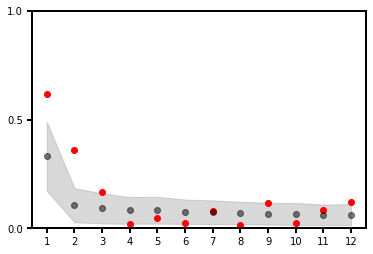

In [25]:
pca_cooccur = PCA(n_components=12)
data_cooccur = np.mean(beta_true_novelty[0], axis=0)[:,0].T
pca_cooccur.fit(data_cooccur.T)

pca_senti = PCA(n_components=12)
data_senti = np.mean(beta_true_novelty[0], axis=0)[:,1].T
pca_senti.fit(data_senti.T)

pc_loading_sim_mat = np.array([cos_sim(pca_cooccur.components_[i], pca_senti.components_[i]) for i in range(12)])
pc_loading_sim_mat[pc_loading_sim_mat > 0] = 1
pc_loading_sim_mat[pc_loading_sim_mat < 0] = -1

# theta_true = np.array([theta(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])
# plt.figure()
# plt.plot(theta_true, 'ko-')
# plt.plot(np.mean(thetas, axis=0), 'ko-', alpha = 0.3)
# errorh = np.std(thetas, axis=0)
# plt.fill_between(np.arange(12), np.mean(thetas, axis=0)-errorh, np.mean(thetas, axis=0)+errorh, alpha = 0.3,color = 'grey')
# plt.ylim([43, 92])
# plt.xticks(np.arange(12), np.arange(1,12+1))
# plt.yticks([45,90])

cos_true = np.array([cos_sim(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])
plt.plot(cos_true, 'ro')
plt.plot(np.mean(thetas, axis=0), 'ko', alpha = 0.5)
errorh = np.std(thetas, axis=0)
plt.fill_between(np.arange(12), np.mean(thetas, axis=0)-errorh, np.mean(thetas, axis=0)+errorh, alpha = 0.3,color = 'grey')
plt.ylim([-0.0, 1.0])
plt.xticks(np.arange(12), np.arange(1,12+1))
plt.yticks([0,0.5,1])

print([np.sum(thetas[:,pc] > cos_true[pc])/repetition for pc in range(12)])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Principal_angle_novelty2.png',dpi=300, bbox_inches = "tight")

In [14]:
from numpy import arccos, arctan
from numpy.linalg import norm
import math

def theta(v, w): return np.rad2deg(arccos(v.dot(w)/(norm(v)*norm(w))))
thetas = []
for repeat in range(1000):
    pca_cooccur = PCA(n_components=12)
    data_cooccur = np.mean(beta_perm_memory[0][repeat], axis=0)[:,0].T
    pca_cooccur.fit(data_cooccur.T)

    pca_senti = PCA(n_components=12)
    data_senti = np.mean(beta_true_recall[0], axis=0)[:,0].T
    pca_senti.fit(data_senti.T)

    pc_loading_sim_mat = np.array([cos_sim(pca_cooccur.components_[i], pca_senti.components_[i]) for i in range(12)])
    pc_loading_sim_mat[pc_loading_sim_mat > 0] = 1
    pc_loading_sim_mat[pc_loading_sim_mat < 0] = -1

    # thetas.append([theta(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])
    thetas.append([cos_sim(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])
thetas = np.array(thetas)

pca_cooccur = PCA(n_components=12)
data_cooccur = np.mean(beta_true_memory[0], axis=0)[:,0].T
pca_cooccur.fit(data_cooccur.T)

pca_senti = PCA(n_components=12)
data_senti = np.mean(beta_true_recall[0], axis=0)[:,0].T
pca_senti.fit(data_senti.T)

pc_loading_sim_mat = np.array([cos_sim(pca_cooccur.components_[i], pca_senti.components_[i]) for i in range(12)])
pc_loading_sim_mat[pc_loading_sim_mat > 0] = 1
pc_loading_sim_mat[pc_loading_sim_mat < 0] = -1

theta_true = np.array([cos_sim(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(12)])

[0.036, 0.651, 0.637, 0.644, 0.955, 0.644, 0.202, 0.033, 0.378, 0.173, 0.539, 0.018]


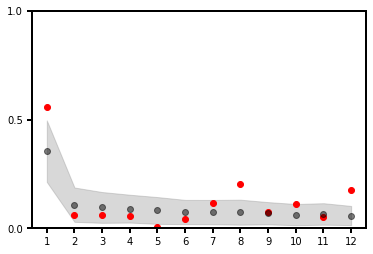

In [18]:
plt.plot(theta_true, 'ro')
plt.plot(np.mean(thetas, axis=0), 'ko', alpha = 0.5)
errorh = np.std(thetas, axis=0)
plt.fill_between(np.arange(12), np.mean(thetas, axis=0)-errorh, np.mean(thetas, axis=0)+errorh, alpha = 0.3,color = 'grey')
plt.ylim([-0.0, 1.0])
plt.xticks(np.arange(12), np.arange(1,12+1))
plt.yticks([0,0.5,1])

# cos_true = np.array([cos_sim(pca_cooccur.components_[pc], pc_loading_sim_mat[pc]*pca_senti.components_[pc]) for pc in range(20)])
# plt.plot(cos_true, 'ro-')
# plt.plot(np.mean(thetas, axis=0), 'ko-')
# errorh = np.std(thetas, axis=0)*2
# plt.fill_between(np.arange(20), np.mean(thetas, axis=0)-errorh, np.mean(thetas, axis=0)+errorh, alpha = 0.3,color = 'grey')
# plt.ylim([-0.05, 1.05])
# plt.yticks([0,0.5,1])

print([np.sum(thetas[:,pc] > theta_true[pc])/1000 for pc in range(12)])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Principal_angle_memory_recall2.png',dpi=300, bbox_inches = "tight")

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

num_pcs = 5

pca_1 = PCA(n_components=window_length)
data_1 = np.mean(beta_true_novelty[0], axis=0)[:,0].T
pca_1.fit(data_1.T)

direction = [1] * 5 # [1,-1,1,-1,1]

fig = plt.figure(figsize=(num_pcs*3, 3))
for i in range(num_pcs):
    x = np.hstack([np.where(mask == r)[0] for r in [215,216,217,218]])
    y = np.hstack([np.where(mask == r)[1] for r in [215,216,217,218]])
    z = np.hstack([np.where(mask == r)[2] for r in [215,216,217,218]])

    xyz = np.vstack([x,y,z])
    density = pca_1.components_[i] * direction[i]

    idx = density.argsort()
    x, y, z, density = x[idx], y[idx], z[idx], density[idx]

    axs = fig.add_subplot(1,num_pcs,i+1, projection='3d')
    axs.scatter(x, y, z, c=density, cmap = "RdYlBu_r", alpha = 0.5, marker = "o", linewidth = 3, vmin = -0.1, vmax = 0.1)

    axs.grid(False)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_zticks([])
    axs.view_init(30, 60)

fig.tight_layout()
plt.imshow

# fig.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/PC_gradients_recall_start.png',dpi=300, bbox_inches = "tight")

In [ ]:
'''
0: novelty vs. novelty
1: novelty vs. canonical
2: memory vs. canonical
3: novelty vs. memory
4: novelty vs. recall
5: memory vs. recall
'''

pca_memory_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_memory[0], axis=0)[:,0].T
pca_memory_true.fit(data_1.T)

pca_recall_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_recall[0], axis=0)[:,0].T
pca_recall_true.fit(data_1.T)

pca_novelty_co_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_novelty[0], axis=0)[:,0].T
pca_novelty_co_true.fit(data_1.T)

pca_novelty_val_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_novelty[0], axis=0)[:,1].T
pca_novelty_val_true.fit(data_1.T)

# 0
true = cos_sim(pca_novelty_co_true.components_[0], pca_novelty_val_true.components_[0])

perm = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_co = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,0].T
    pca_novelty_co.fit(data_1.T)

    pca_novelty_val = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,1].T
    pca_novelty_val.fit(data_1.T)

    perm.append(cos_sim(pca_novelty_co.components_[0], pca_novelty_val.components_[0]))
cooccur_valence_true = true
cooccur_valence_perm = perm

# 1
true1 = cos_sim(pca_novelty_co_true.components_[0], pca_canonical.components_[0])
true2 = cos_sim(pca_novelty_co_true.components_[0], pca_canonical.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_co = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,0].T
    pca_novelty_co.fit(data_1.T)

    perm1.append(cos_sim(pca_novelty_co.components_[0], pca_canonical.components_[0]))
    perm2.append(cos_sim(pca_novelty_co.components_[0], pca_canonical.components_[1]))
cooccur_canon1_true = true1
cooccur_canon1_perm = perm1
cooccur_canon2_true = true2
cooccur_canon2_perm = perm2

true1 = cos_sim(pca_novelty_val_true.components_[0], pca_canonical.components_[0])
true2 = cos_sim(pca_novelty_val_true.components_[0], pca_canonical.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_val = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,1].T
    pca_novelty_val.fit(data_1.T)

    perm1.append(cos_sim(pca_novelty_val.components_[0], pca_canonical.components_[0]))
    perm2.append(cos_sim(pca_novelty_val.components_[0], pca_canonical.components_[1]))
valence_canon1_true = true1
valence_canon1_perm = perm1
valence_canon2_true = true2
valence_canon2_perm = perm2

# 2
true1 = cos_sim(pca_memory_true.components_[0], pca_canonical.components_[0])
true2 = cos_sim(pca_memory_true.components_[0], pca_canonical.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_memory[0])):

    pca_memory = PCA(n_components=2)
    data_1 = np.mean(beta_perm_memory[0][r], axis=0)[:,0].T
    pca_memory.fit(data_1.T)

    perm1.append(cos_sim(pca_memory.components_[0], pca_canonical.components_[0]))
    perm2.append(cos_sim(pca_memory.components_[0], pca_canonical.components_[1]))
memory_canon1_true = true1
memory_canon1_perm = perm1
memory_canon2_true = true2
memory_canon2_perm = perm2

# 3
true1 = cos_sim(pca_novelty_co_true.components_[0], pca_memory_true.components_[0])
true2 = cos_sim(pca_novelty_co_true.components_[0], pca_memory_true.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_co = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,0].T
    pca_novelty_co.fit(data_1.T)

    pca_memory = PCA(n_components=2)
    data_1 = np.mean(beta_perm_memory[0][r], axis=0)[:,0].T
    pca_memory.fit(data_1.T)

    perm1.append(cos_sim(pca_novelty_co.components_[0], pca_memory.components_[0]))
    perm2.append(cos_sim(pca_novelty_co.components_[0], pca_memory.components_[1]))
cooccur_memory1_true = true1
cooccur_memory1_perm = perm1
cooccur_memory2_true = true2
cooccur_memory2_perm = perm2

true1 = cos_sim(pca_novelty_val_true.components_[0], pca_memory_true.components_[0])
true2 = cos_sim(pca_novelty_val_true.components_[0], pca_memory_true.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_val = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,1].T
    pca_novelty_val.fit(data_1.T)

    pca_memory = PCA(n_components=2)
    data_1 = np.mean(beta_perm_memory[0][r], axis=0)[:,0].T
    pca_memory.fit(data_1.T)

    perm1.append(cos_sim(pca_novelty_val.components_[0], pca_memory.components_[0]))
    perm2.append(cos_sim(pca_novelty_val.components_[0], pca_memory.components_[1]))
valence_memory1_true = true1
valence_memory1_perm = perm1
valence_memory2_true = true2
valence_memory2_perm = perm2

# 4
true1 = cos_sim(pca_novelty_co_true.components_[0], pca_recall_true.components_[0])
true2 = cos_sim(pca_novelty_co_true.components_[0], pca_recall_true.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_co = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,0].T
    pca_novelty_co.fit(data_1.T)

    perm1.append(cos_sim(pca_novelty_co.components_[0], pca_recall_true.components_[0]))
    perm2.append(cos_sim(pca_novelty_co.components_[0], pca_recall_true.components_[1]))
cooccur_recall1_true = true1
cooccur_recall1_perm = perm1
cooccur_recall2_true = true2
cooccur_recall2_perm = perm2

true1 = cos_sim(pca_novelty_val_true.components_[0], pca_recall_true.components_[0])
true2 = cos_sim(pca_novelty_val_true.components_[0], pca_recall_true.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_novelty[0])):

    pca_novelty_val = PCA(n_components=2)
    data_1 = np.mean(beta_perm_novelty[0][r], axis=0)[:,1].T
    pca_novelty_val.fit(data_1.T)
    
    perm1.append(cos_sim(pca_novelty_val.components_[0], pca_recall_true.components_[0]))
    perm2.append(cos_sim(pca_novelty_val.components_[0], pca_recall_true.components_[1]))
valence_recall1_true = true1
valence_recall1_perm = perm1
valence_recall2_true = true2
valence_recall2_perm = perm2

# 5
true1 = cos_sim(pca_memory_true.components_[0], pca_recall_true.components_[0])
true2 = cos_sim(pca_memory_true.components_[1], pca_recall_true.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_memory[0])):

    pca_memory = PCA(n_components=2)
    data_1 = np.mean(beta_perm_memory[0][r], axis=0)[:,0].T
    pca_memory.fit(data_1.T)

    perm1.append(cos_sim(pca_memory.components_[0], pca_recall_true.components_[0]))
    perm2.append(cos_sim(pca_memory.components_[1], pca_recall_true.components_[1]))
memory_recall1_true = true1
memory_recall1_perm = perm1
memory_recall2_true = true2
memory_recall2_perm = perm2

In [ ]:
true1 = cos_sim(pca_recall_true.components_[0], pca_canonical.components_[0])
true2 = cos_sim(pca_recall_true.components_[0], pca_canonical.components_[1])

perm1 = []
perm2 = []
for r in range(len(beta_perm_recall[0])):

    pca_memory = PCA(n_components=2)
    data_1 = np.mean(beta_perm_recall[0][r], axis=0)[:,0].T
    pca_memory.fit(data_1.T)

    perm1.append(cos_sim(pca_memory.components_[0], pca_canonical.components_[0]))
    perm2.append(cos_sim(pca_memory.components_[0], pca_canonical.components_[1]))
memory_canon1_true = true1
memory_canon1_perm = perm1
memory_canon2_true = true2
memory_canon2_perm = perm2

In [ ]:
pca_memory_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_memory[0], axis=0)[:,0].T
pca_memory_true.fit(data_1.T)

pca_recall_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_recall[0], axis=0)[:,0].T
pca_recall_true.fit(data_1.T)

pca_novelty_co_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_novelty[0], axis=0)[:,0].T
pca_novelty_co_true.fit(data_1.T)

pca_novelty_val_true = PCA(n_components=window_length)
data_1 = np.mean(beta_true_novelty[0], axis=0)[:,1].T
pca_novelty_val_true.fit(data_1.T)

PCA(n_components=21)

In [ ]:
memory_recall1_true = []
memory_recall1_perm = []

for pc in range(12):
    true1 = cos_sim(pca_memory_true.components_[pc], pca_recall_true.components_[pc])

    perm1 = []
    for r in range(len(beta_perm_memory[0])):

        pca_memory = PCA(n_components=12)
        data_1 = np.mean(beta_perm_memory[0][r], axis=0)[:,0].T
        pca_memory.fit(data_1.T)

        perm1.append(cos_sim(pca_memory.components_[pc], pca_recall_true.components_[pc]))
    memory_recall1_true.append(true1)
    memory_recall1_perm.append(perm1)

In [ ]:
for pc in range(12):
    true = memory_recall1_true[pc]
    perm = memory_recall1_perm[pc]
    print(np.abs(true), np.sum(np.abs(perm) > np.abs(true))/1000)

0.5573044342552191 0.036
0.06275964941110287 0.651
0.059575611601572494 0.637
0.05652258822272952 0.644
0.005256792884403105 0.955
0.042978357251516164 0.644
0.11810075872030155 0.202
0.20164512885370067 0.033
0.07477764643821444 0.378
0.11308784826278541 0.173
0.05281615935090403 0.539
0.1762058523737881 0.018


(0.0, 1.05)

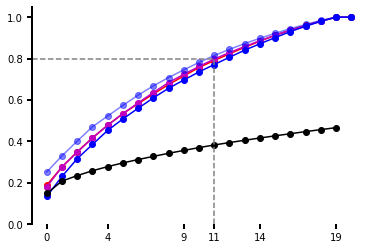

In [ ]:
plt.plot(np.cumsum(pca_novelty_co_true.explained_variance_ratio_), 'ro-')
plt.plot(np.cumsum(pca_novelty_val_true.explained_variance_ratio_), 'mo-')
plt.plot(np.cumsum(pca_memory_true.explained_variance_ratio_), 'bo-', alpha = 0.5)
plt.plot(np.cumsum(pca_recall_true.explained_variance_ratio_), 'bo-')
plt.plot(np.cumsum(pca_canonical.explained_variance_ratio_), 'ko-')
plt.vlines(11,0,0.8,  color = 'grey', linestyle = '--')
plt.hlines(0.8, -1,11, color = 'grey', linestyle = '--')
plt.xticks([0,4,9,11,14,19])
plt.xlim([-1,21])
plt.ylim([0,1.05])
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/PC_explained_variance.png',dpi=300, bbox_inches = "tight")

In [ ]:
corr_look = np.abs([cooccur_memory2_true, valence_memory2_true, cooccur_recall2_true, valence_recall2_true])
random_look = np.abs([cooccur_memory2_perm, valence_memory2_perm, cooccur_recall2_perm, valence_recall2_perm])
# chance_level = [np.sort(random_look[c])[949] for c in range(4)]

x_pos = [0,0.4,1,1.4]
plt.figure(figsize = [6.5,4])
plt.xticks(x_pos, fontsize = 12)
plt.yticks([0,0.3,0.6], fontsize = 12)
plt.xlim([-0.4,1.8])
plt.hlines([0],-1,5, 'black', linewidth = 1, linestyle = '--')
for i in range(len(corr_look)):
    if i in [0,2]:
        plt.scatter(x_pos[i], corr_look[i], color = 'red', marker = 'D', zorder = 2)
    else:
        plt.scatter(x_pos[i], corr_look[i], color = 'magenta', marker = 'D', zorder = 2)

for c in range(4):
    plt.hlines(chance_level[c], x_pos[c]-0.15, x_pos[c]+0.15, color = 'grey', linestyle = '--')

for c in range(4):
    plt.scatter(np.random.normal(size=1000)/30 + x_pos[c], random_look[c], color = 'grey', alpha = 0.2)


# violin_parts = plt.violinplot(random_look.T, x_pos, showmeans=False, showmedians=False, showextrema=False, widths = 0.25)
# count = 0
# for vp in violin_parts['bodies']:
#     if count in [0,1]:
#         vp.set_facecolor('#2D639E')
#     else:
#         vp.set_facecolor('#8190B5')
#     vp.set_alpha(0.5)
#     count += 1

plt.ylim([0, 0.6])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Alignment_angle_novelty_movie_recall.png',dpi=300, bbox_inches = "tight")

#### Encoding performance

##### Linear arrangement

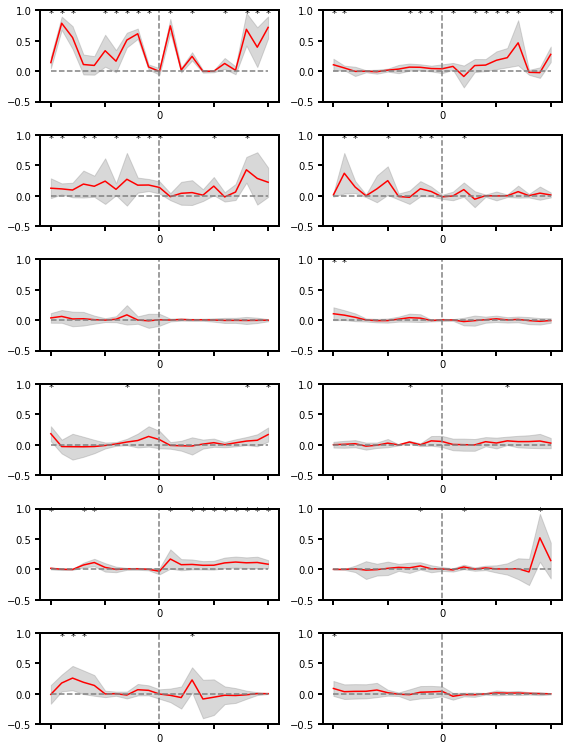

In [39]:
# from sklearn.metrics import r2_score
from scipy.spatial.distance import pdist, cdist

pc_90 = np.array([np.arange(np.sum(pc1_evs[r] < 0.8)+1).astype('int') for r in range(len(patterns))])
# pc_90[pc_90 < 3] = 3
# pc_90 = [[1]] * len(patterns)

true_est_poses = []
r2_trues = []
r2_perms = []
pvalues = []
fig = plt.figure(figsize = [8,12])
for roi_num in range(len(patterns)):
    fMRI_data_true = memory_space_memory_true[roi_num]
    fMRI_data_perm = memory_space_memory_perm[roi_num]

    # model_data = [np.mean(memorability[ev]) for ev in [recall_9_pool, recall_8_pool, recall_7_pool, recall_6_pool, recall_5_pool, recall_4_pool, recall_3_pool, recall_2_pool, recall_1_pool]]
    # model_data = [np.mean(valence[ev]) for ev in np.array_split(np.argsort(-valence), 9)]
    model_data = [-4,-3,-2,-1,0,1,2,3,4]
    # model_data = [-1,-1,-1,0,0,0,1,1,1]  
    # model_data = [-1,0,1,-1,0,1,-1,0,1]  
    # model_data = [-5,-3,-1,1,3,5]

    axs = fig.add_subplot(7,2,roi_num+1)
    true_est_pos = []
    r2_true = []
    for t in range(window_length):
        distance_mat = cdist(fMRI_data_true[:,pc_90[roi_num],t], fMRI_data_true[:,pc_90[roi_num],t])
        len_from_p1 = []
        for c in range(fMRI_data_true.shape[0]):
            p1 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][1],pc_90[roi_num],t]
            p2 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][0],pc_90[roi_num],t] 
            p3 = fMRI_data_true[c,pc_90[roi_num],t] 

            unit_length = np.linalg.norm(p1-p2)
            l2 = np.sum((p1-p2)**2)
            a = np.sum((p3 - p1) * (p2 - p1)) / l2
            a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
            projection = p1 + a * (p2 - p1)
            len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
        r2_true.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)
        true_est_pos.append(len_from_p1)
    true_est_poses.append(true_est_pos)

    r2_perm = []
    for repeat in range(len(fMRI_data_perm)):
        r2 = []
        for t in range(window_length):
            distance_mat = cdist(fMRI_data_perm[repeat][:,pc_90[roi_num],t], fMRI_data_perm[repeat][:,pc_90[roi_num],t])  
            len_from_p1 = []
            for c in range(fMRI_data_true.shape[0]):
                p1 = fMRI_data_perm[repeat][np.where(distance_mat == np.max(distance_mat))[0][1],pc_90[roi_num],t]
                p2 = fMRI_data_perm[repeat][np.where(distance_mat == np.max(distance_mat))[0][0],pc_90[roi_num],t] 
                p3 = fMRI_data_perm[repeat][c,pc_90[roi_num],t] 

                unit_length = np.linalg.norm(p1-p2)
                l2 = np.sum((p1-p2)**2)
                a = np.sum((p3 - p1) * (p2 - p1)) / l2
                a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
                projection = p1 + a * (p2 - p1)
                len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
            r2.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)
        r2_perm.append(r2)

    r2_trues.append(r2_true)
    r2_perms.append(r2_perm)
    r2_true = np.array(r2_true)
    r2_perm = np.array(r2_perm)

    # axs.plot(r2_true, 'r')
    # axs.plot(np.mean(r2_perm, axis=0), 'grey')
    # errorh = np.array([np.std(r2_perm[:,t])*2 for t in range(window_length)])
    # axs.fill_between(np.arange(window_length), np.mean(r2_perm, axis=0)-errorh,np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')
    
    axs.plot(r2_true-np.mean(r2_perm, axis=0), 'r')
    errorh = np.array([np.std(r2_true[t] - r2_perm[:,t])*2 for t in range(window_length)])
    axs.fill_between(np.arange(window_length), r2_true-np.mean(r2_perm, axis=0)-errorh,r2_true-np.mean(r2_perm, axis=0)+errorh, alpha = 0.3,color = 'grey')
    
    axs.set_ylim([-0.5,1])
    axs.hlines(0, 0, window_length-1, linestyle = '--', color = 'grey')
    axs.vlines(10, -1, 1, linestyle = '--', color = 'grey')
    axs.set_xticks([0,5,10,15,20])
    axs.set_xticklabels(['','',0,'',''])
    pvalues.append([np.sum(r2_perm[:,t] > r2_true[t])/repetition for t in range(window_length)])
    for t in range(21):
        if np.sum(r2_perm[:,t] > r2_true[t])/repetition < .05:
            plt.text(t-0.2,0.9,'*')
r2_trues = np.array(r2_trues)
r2_perms = np.array(r2_perms)
fig.tight_layout()
fig.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Memory_space_memory_r2_3.png', dpi=300, bbox_inches = "tight")

In [32]:
pvalues[3]

[0.056,
 0.216,
 0.164,
 0.005,
 0.385,
 0.265,
 0.082,
 0.012,
 0.268,
 0.301,
 0.081,
 0.374,
 0.28,
 0.01,
 0.033,
 0.002,
 0.175,
 0.023,
 0.299,
 0.033,
 0.095]

In [675]:
before = np.mean(r2_trues[:,:10], axis=1) - np.mean(r2_perms[:,:,:10], axis=2).T
after = np.mean(r2_trues[:,11:], axis=1) - np.mean(r2_perms[:,:,11:], axis=2).T
# Memory_space_cooccur_before = np.hstack([np.mean(r2_trues[:,:10]), np.mean(r2_perms[0,:,:10], axis=1)])
# Memory_space_cooccur_after = np.hstack([np.mean(r2_trues[:,11:]), np.mean(r2_perms[0,:,11:], axis=1)])

# before = np.mean(r2_trues[:,:10], axis=1) - np.mean(r2_perms[:,:,:10], axis=2).T
# after = np.mean(r2_trues[:,11:], axis=1) - np.mean(r2_perms[:,:,11:], axis=2).T
# Memory_space_valence_before = np.hstack([np.mean(r2_trues[:,:10]), np.mean(r2_perms[0,:,:10], axis=1)])
# Memory_space_valence_after = np.hstack([np.mean(r2_trues[:,11:]), np.mean(r2_perms[0,:,11:], axis=1)])

In [ ]:
plt.figure(figsize = [4,5])
bar1 = plt.bar([0], [np.mean(before)], color = 'navy', edgecolor = 'k', linewidth = 3, width = 0.7, alpha = 0.5) # #FF0000 #9C27B0 #656B83
plt.bar([1], [np.mean(after)], color = 'navy', edgecolor = 'k', linewidth = 3, width = 0.7) # #FF0000 #9C27B0 navy
# plt.errorbar([0,1], [np.mean(before), np.mean(after)], [np.std(before)*2, np.std(after)*2], linestyle = '', color = 'k', linewidth = 3)
plt.scatter(np.random.normal(size = 1000)/15, before, color = 'grey', alpha = 0.1)
plt.scatter(np.random.normal(size = 1000)/15 + 1 , after, color = 'grey', alpha = 0.1)
plt.xlim([-0.6, 1.6])
plt.ylim([0,0.8])
plt.xticks([0,1])
plt.yticks([0,0.4,0.8])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Memory_summary.png', dpi=300, bbox_inches = "tight")

In [ ]:
# corr_look = np.array([zscore(Memory_space_cooccur_before)[0], zscore(Memory_space_valence_before)[0],
#                       zscore(Memory_space_cooccur_after)[0], zscore(Memory_space_valence_after)[0]])
# random_look = np.array([zscore(Memory_space_cooccur_before)[1:], zscore(Memory_space_valence_before)[1:],
#                         zscore(Memory_space_cooccur_after)[1:], zscore(Memory_space_valence_after)[1:]])

corr_look = np.array([Memory_space_cooccur_before[0], Memory_space_valence_before[0],  
                      Memory_space_cooccur_after[0], Memory_space_valence_after[0]])
random_look = np.array([Memory_space_cooccur_before[1:], Memory_space_valence_before[1:],
                        Memory_space_cooccur_after[1:], Memory_space_valence_after[1:]])
diff = np.array([corr_look]).T - random_look

x_pos = [0,0.4,1,1.4]
plt.figure(figsize = [6.5,4])
plt.xticks(x_pos, fontsize = 12)
plt.yticks([-0.1,0,0.1,0.2,0.3,0.4], fontsize = 12)
plt.xlim([-0.4,1.8])
plt.hlines([0],-1,5, 'black', linewidth = 1, linestyle = '--')

barlist = plt.bar(x_pos, np.mean(diff, axis=1), width = 0.3, edgecolor = 'k', alpha = 1)
barlist[0].set_facecolor('#FF0000')
barlist[0].set_alpha(0.5)
barlist[1].set_facecolor('#9C27B0')
barlist[1].set_alpha(0.5)
barlist[2].set_facecolor('#FF0000')
barlist[3].set_facecolor('#9C27B0')
plt.errorbar(x_pos, np.mean(diff, axis=1), np.std(diff, axis=1), linestyle = '', color = 'k')

# plt.scatter(x_pos[0], corr_look[0], color = 'red', marker = 'D', zorder = 2, linewidth = 3, alpha = 1)
# plt.scatter(x_pos[1], corr_look[2], color = 'red', marker = 'D', zorder = 2, linewidth = 3, alpha = 1)
# plt.scatter(x_pos[2], corr_look[1], color = '#9C27B0', marker = 'D', zorder = 2, linewidth = 3, alpha = 1)
# plt.scatter(x_pos[3], corr_look[3], color = '#9C27B0', marker = 'D', zorder = 2, linewidth = 3, alpha = 1)

# violin_parts = plt.violinplot(random_look.T, x_pos, showmeans=False, showmedians=False, showextrema=False, widths = 0.25)
# count = 0
# for vp in violin_parts['bodies']:
#     if count in [0,1]:
#         vp.set_facecolor('#2D639E')
#     else:
#         vp.set_facecolor('#2D639E') #8190B5
#     vp.set_alpha(0.5)
#     count += 1

plt.ylim([-0.1, 0.4])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Memory_space_novelty_encoding2.png',dpi=300, bbox_inches = "tight")

In [ ]:
tp = 16
fig = plt.figure(figsize = [5,5])
fig.gca().set_prop_cycle(plt.cycler('color', plt.cm.RdYlBu_r(np.linspace(0, 1, 9))))
# plt.scatter(p_c1_trues[0][[0,3,6],0,tp], p_c1_trues[0][[0,3,6],1,tp], marker = 'o', color = 'magenta', linewidths = 5)
# plt.scatter(p_c1_trues[0][[1,4,7],0,tp], p_c1_trues[0][[1,4,7],1,tp], marker = 'o', color = 'grey', linewidths = 5)
# plt.scatter(p_c1_trues[0][[2,5,8],0,tp], p_c1_trues[0][[2,5,8],1,tp], marker = 'o', color = 'cyan', linewidths = 5)
for c in range(9):
    plt.scatter(p_c1_trues[0][c,0,tp], p_c1_trues[0][c,2,tp], marker = 'o',linewidths = 5)
plt.xticks([])
plt.yticks([])
plt.plot([p_c1_trues[0][6,0,tp], p_c1_trues[0][0,0,tp]], [p_c1_trues[0][6,2,tp], p_c1_trues[0][0,2,tp]], color = 'k', zorder = 0)
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Cooccur_space_memory_example.png', dpi=300, bbox_inches = "tight")

In [ ]:
t = 10
roi_num = 0
fMRI_data_true = p_c1_trues[roi_num]
distance_mat = cdist(fMRI_data_true[:,[0,1,2],t], fMRI_data_true[:,[0,1,2],t])
len_from_p1 = []
for c in range(fMRI_data_true.shape[0]):
    p1 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][1],[0,1,2],t]
    p2 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][0],[0,1,2],t] 
    p3 = fMRI_data_true[c,[0,1,2],t] 

    unit_length = np.linalg.norm(p1-p2)
    l2 = np.sum((p1-p2)**2)
    a = np.sum((p3 - p1) * (p2 - p1)) / l2
    a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
    projection = p1 + a * (p2 - p1)
    len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)

fig = plt.figure()
fig.gca().set_prop_cycle(plt.cycler('color', plt.cm.RdYlBu_r(np.linspace(0, 1, 9))))
for p in range(9):
    plt.scatter([0],len_from_p1[p],zorder=2,linewidths=3)
plt.vlines(0,0,1,'grey',zorder=1)
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Cooccur_vs_valence_v3/a1.png', dpi=300, bbox_inches = "tight")

In [706]:
cumulative = False
r2_trues = []
r2_perms = []
pvalues = []
# for num in range(1):
for num in [2]:
    fMRI_data_true = memory_space_novelty_true[0]
    fMRI_data_perm = memory_space_novelty_perm[0]
    model_data = [-1,-1,-1,0,0,0,1,1,1]  
    # model_data = [-1,0,1,-1,0,1,-1,0,1] 
    # model_data = [-4,-3,-2,-1,0,1,2,3,4]

    if cumulative:
        r2_true = []
        for t in range(window_length):
            distance_mat = cdist(fMRI_data_true[:,:num,t], fMRI_data_true[:,:num,t])
            len_from_p1 = []
            for c in range(fMRI_data_true.shape[0]):
                p1 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][1],:num,t]
                p2 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][0],:num,t] 
                p3 = fMRI_data_true[c,:num,t] 

                unit_length = np.linalg.norm(p1-p2)
                l2 = np.sum((p1-p2)**2)
                a = np.sum((p3 - p1) * (p2 - p1)) / l2
                a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
                projection = p1 + a * (p2 - p1)
                len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
            r2_true.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)

        r2_perm = []
        for repeat in range(repetition):
            r2 = []
            for t in range(window_length):
                distance_mat = cdist(fMRI_data_perm[repeat][:,:num,t], fMRI_data_perm[repeat][:,:num,t])  
                len_from_p1 = []
                for c in range(fMRI_data_true.shape[0]):
                    p1 = fMRI_data_perm[repeat][np.where(distance_mat == np.max(distance_mat))[0][1],:num,t]
                    p2 = fMRI_data_perm[repeat][np.where(distance_mat == np.max(distance_mat))[0][0],:num,t] 
                    p3 = fMRI_data_perm[repeat][c,:num,t] 

                    unit_length = np.linalg.norm(p1-p2)
                    l2 = np.sum((p1-p2)**2)
                    a = np.sum((p3 - p1) * (p2 - p1)) / l2
                    a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
                    projection = p1 + a * (p2 - p1)
                    len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
                r2.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)
            r2_perm.append(r2)
    else:
        r2_true = []
        for t in range(window_length):
            distance_mat = cdist(fMRI_data_true[:,[num-1],t], fMRI_data_true[:,[num-1],t])
            len_from_p1 = []
            for c in range(fMRI_data_true.shape[0]):
                p1 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][1],[num-1],t]
                p2 = fMRI_data_true[np.where(distance_mat == np.max(distance_mat))[0][0],[num-1],t] 
                p3 = fMRI_data_true[c,[num-1],t] 

                unit_length = np.linalg.norm(p1-p2)
                l2 = np.sum((p1-p2)**2)
                a = np.sum((p3 - p1) * (p2 - p1)) / l2
                a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
                projection = p1 + a * (p2 - p1)
                len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
            r2_true.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)

        r2_perm = []
        for repeat in range(repetition):
            r2 = []
            for t in range(window_length):
                distance_mat = cdist(fMRI_data_perm[repeat][:,[num-1],t], fMRI_data_perm[repeat][:,[num-1],t])  
                len_from_p1 = []
                for c in range(fMRI_data_true.shape[0]):
                    p1 = fMRI_data_perm[repeat][np.where(distance_mat == np.max(distance_mat))[0][1],[num-1],t]
                    p2 = fMRI_data_perm[repeat][np.where(distance_mat == np.max(distance_mat))[0][0],[num-1],t] 
                    p3 = fMRI_data_perm[repeat][c,[num-1],t] 

                    unit_length = np.linalg.norm(p1-p2)
                    l2 = np.sum((p1-p2)**2)
                    a = np.sum((p3 - p1) * (p2 - p1)) / l2
                    a = max(0, min(1, np.sum((p3 - p1) * (p2 - p1)) / l2))
                    projection = p1 + a * (p2 - p1)
                    len_from_p1.append(np.linalg.norm(p1 - projection)/unit_length)
                r2.append(sm.OLS(len_from_p1, sm.add_constant(model_data)).fit().rsquared)
            r2_perm.append(r2)

    r2_trues.append(r2_true)
    r2_perms.append(r2_perm)
    r2_true = np.array(r2_true)
    r2_perm = np.array(r2_perm)
r2_trues = np.array(r2_trues)
r2_perms = np.array(r2_perms)

In [707]:
before = np.mean(r2_trues[:,:10], axis=1) - np.mean(r2_perms[:,:,:10], axis=2).T
after = np.mean(r2_trues[:,11:], axis=1) - np.mean(r2_perms[:,:,11:], axis=2).T

# before_cooccur_cooccur = before
# after_cooccur_cooccur = after

# before_cooccur_valence = before
# after_cooccur_valence = after

# before_valence_cooccur = before
# after_valence_cooccur = after

# before_valence_valence = before
# after_valence_valence = after

# before_cooccur_cooccur_each = before
# after_cooccur_cooccur_each = after

# before_cooccur_valence_each = before
# after_cooccur_valence_each = after

# before_valence_valence_each = before
# after_valence_valence_each = after

# before_valence_cooccur_each = before
# after_valence_cooccur_each = after

before_cooccur_memory_each = before
after_cooccur_memory_each = after

# before_valence_memory_each = before
# after_valence_memory_each = after

In [ ]:
print(np.mean(before_cooccur_valence_each, axis=0), 
      [np.sum(before_cooccur_valence_each[:,i] < 0)/repetition for i in range(12)])
print(np.mean(after_cooccur_valence_each, axis=0), 
      [np.sum(after_cooccur_valence_each[:,i] < 0)/repetition for i in range(12)])

In [ ]:
plt.figure(figsize = [8,5])
# plt.errorbar(np.arange(len(before_cooccur_valence.T)), np.mean(before_cooccur_valence, axis=0), np.std(before_cooccur_valence, axis=0), color = 'm', alpha = 0.33)
# plt.errorbar(np.arange(len(after_cooccur_valence.T)), np.mean(after_cooccur_valence, axis=0), np.std(after_cooccur_valence, axis=0), color = 'm')
# plt.errorbar(np.arange(len(before_cooccur_cooccur.T)), np.mean(before_cooccur_cooccur, axis=0), np.std(before_cooccur_cooccur, axis=0), color = 'r', alpha = 0.33)
# plt.errorbar(np.arange(len(after_cooccur_cooccur.T)), np.mean(after_cooccur_cooccur, axis=0), np.std(after_cooccur_cooccur, axis=0), color = 'r')

# plt.errorbar(np.arange(12), np.mean(before_valence_cooccur_each, axis=0), np.std(before_valence_cooccur_each, axis=0), color = 'm', alpha = 0.33)
# plt.errorbar(np.arange(12), np.mean(after_valence_cooccur_each, axis=0), np.std(after_valence_cooccur_each, axis=0), color = 'm')
plt.errorbar(np.arange(12), np.mean(before_cooccur_valence_each, axis=0), np.std(before_cooccur_valence_each, axis=0), color = 'r', alpha = 0.33)
plt.errorbar(np.arange(12), np.mean(after_cooccur_valence_each, axis=0), np.std(after_cooccur_valence_each, axis=0), color = 'r')

plt.xticks(np.arange(12),np.arange(1,13))
plt.xlim([-1,12])    
plt.ylim([-0.2,0.4])
# plt.ylim([-0.1,0.6])
plt.hlines(0,-1,20, color = 'grey', linestyle = '--')
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Encoding_performance_cooccur_space_valence_each_pc.png', dpi=300, bbox_inches = "tight")

In [ ]:
befores = np.array([before_cooccur_cooccur_each, before_cooccur_valence_each, before_valence_cooccur_each, before_valence_valence_each])
afters = np.array([after_cooccur_cooccur_each, after_cooccur_valence_each, after_valence_cooccur_each, after_valence_valence_each])

plt_data = afters[:,:,0]

x_pos = [0,0.4,1,1.4]
plt.figure(figsize = [6,4])
plt.hlines([0],-1,5, 'black', linewidth = 1, linestyle = '--')

# barlist = plt.bar(x_pos, np.mean(plt_data, axis=1), width = 0.3, edgecolor = 'k', alpha = 0.5)
barlist = plt.bar(x_pos, np.mean(plt_data, axis=1), width = 0.3, edgecolor = 'k')
barlist[0].set_facecolor('#FF0000')
barlist[1].set_facecolor('#FF0000')
barlist[1].set_hatch('//')
barlist[2].set_facecolor('#9C27B0')
barlist[2].set_hatch('//')
barlist[3].set_facecolor('#9C27B0')
# plt.errorbar(x_pos, np.mean(plt_data, axis=1), np.std(plt_data, axis=1), linestyle = '', color = 'k')
for c in range(4):
    plt.scatter(np.random.normal(size=1000)/60 + x_pos[c], plt_data[c], color = 'gray', alpha = 0.2)

plt.xticks(x_pos, fontsize = 12)
plt.yticks([-0.2,0,0.2,0.4], fontsize = 12)
plt.xlim([-0.4,1.8])
plt.ylim([-0.2, 0.4])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Figure3b_after.png',dpi=300, bbox_inches = "tight")

In [ ]:
data = np.array([before_cooccur_memory_each, before_valence_memory_each, after_cooccur_memory_each, after_valence_memory_each])

plt_data = data[:,:,0]

x_pos = [0,0.4,1,1.4]
plt.figure(figsize = [6,4])
plt.hlines([0],-1,5, 'black', linewidth = 1, linestyle = '--')

barlist = plt.bar(x_pos, np.mean(plt_data, axis=1), width = 0.3, edgecolor = 'k')
barlist[0].set_facecolor('#FF0000')
barlist[0].set_alpha(0.5)
barlist[1].set_facecolor('#9C27B0')
barlist[1].set_alpha(0.5)
barlist[2].set_facecolor('#FF0000')
barlist[3].set_facecolor('#9C27B0')

for c in range(4):
    plt.scatter(np.random.normal(size=1000)/60 + x_pos[c], plt_data[c], color = 'gray', alpha = 0.2)

plt.xticks(x_pos, fontsize = 12)
plt.yticks([-0.3,0,0.3,0.6], fontsize = 12)
plt.xlim([-0.4,1.8])
plt.ylim([-0.3, 0.6])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Figure4c.png',dpi=300, bbox_inches = "tight")

##### Memory-related cognitive processes

In [ ]:
true1 = []
perm1 = []
true2 = []
perm2 = []
for t in range(21):
    true1.append(cos_sim(zscore(memory_space_memory_true[0][:,1,t]), zscore(novelty_co_space_novelty_true[0][:,0,t])))
    perm1.append(np.array([cos_sim(zscore(memory_space_memory_perm[0][r][:,1,t]), zscore(novelty_co_space_novelty_perm[0][0][:,0,t])) for r in range(1000)]))
    true2.append(cos_sim(zscore(memory_space_memory_true[0][:,1,t]), zscore(novelty_val_space_novelty_true[0][:,0,t])))
    perm2.append(np.array([cos_sim(zscore(memory_space_memory_perm[0][r][:,1,t]), zscore(novelty_val_space_novelty_perm[0][0][:,0,t])) for r in range(1000)]))
    # true1.append(cos_sim(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t]))
    # perm1.append(np.array([cos_sim(memory_space_memory_perm[0][r][:,1,t], novelty_co_space_novelty_perm[0][0][:,0,t]) for r in range(1000)]))
    # true2.append(cos_sim(memory_space_memory_true[0][:,1,t], novelty_val_space_novelty_true[0][:,0,t]))
    # perm2.append(np.array([cos_sim(memory_space_memory_perm[0][r][:,1,t], novelty_val_space_novelty_perm[0][0][:,0,t]) for r in range(1000)]))
true1 = np.array(true1)
true2 = np.array(true2)
perm1 = np.array(perm1)
perm2 = np.array(perm2)
print([np.sum(true1[t] < perm1[t])/1000 for t in range(21)])
print([np.sum(true2[t] < perm2[t])/1000 for t in range(21)])

[0.358, 0.106, 0.547, 0.579, 0.445, 0.696, 0.957, 0.341, 0.381, 0.471, 0.97, 0.707, 0.564, 0.057, 0.015, 0.149, 0.128, 0.249, 0.733, 0.972, 0.592]
[0.446, 0.185, 0.626, 0.44, 0.37, 0.289, 0.983, 0.474, 0.945, 0.789, 0.969, 0.823, 0.232, 0.071, 0.062, 0.207, 0.138, 0.458, 0.746, 0.946, 0.778]


In [ ]:
plt.figure(figsize = [6,3])
true_co = np.array([cos_sim(zscore(memory_space_memory_true[0][:,1,t]), zscore(novelty_co_space_novelty_true[0][:,0,t])) for t in range(window_length)])
# true_co = np.array([cos_sim(memory_space_memory_true[0][:,1,t], novelty_co_space_novelty_true[0][:,0,t]) for t in range(window_length)])
error_co = np.array([np.std(perm1[t]) for t in range(window_length)])
plt.scatter(np.arange(21), true_co, s = 50, color = 'r', edgecolor = 'k', zorder = 3)
plt.plot(true_co,'m',zorder=2)
plt.fill_between(np.arange(window_length), -1, +error_co, alpha = 0.2,color = 'r',zorder=4)

true_val = np.array([cos_sim(zscore(memory_space_memory_true[0][:,1,t]), zscore(novelty_val_space_novelty_true[0][:,0,t])) for t in range(window_length)])
# true_val = np.array([cos_sim(memory_space_memory_true[0][:,1,t], novelty_val_space_novelty_true[0][:,0,t]) for t in range(window_length)])
error_val = np.array([np.std(perm2[t]) for t in range(window_length)])
plt.scatter(np.arange(21), true_val, s = 50, color = 'm', edgecolor = 'k', zorder = 3)
plt.plot(true_val,'m',zorder=2)
plt.fill_between(np.arange(window_length), -1, +error_val, alpha = 0.2,color = 'm',zorder=4)

plt.xlim([-1,21])
plt.ylim([-1,1])
plt.xticks([0,5,10,15,20],['','',0,'',''])
plt.yticks([-1,0,1])    
plt.vlines(10,-1,1,'grey','--',zorder=1)
plt.hlines(0,-1,21,'grey','--',zorder=1)
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Alignment_axis1.png', dpi=300, bbox_inches = "tight")

In [ ]:
timepoint = 10

fig = plt.figure(figsize = [3,6])
fig.gca().set_prop_cycle(plt.cycler('color', plt.cm.RdYlBu(np.linspace(0, 1, 9))))
for p in range(9):
    plt.scatter([0],zscore(memory_space_memory_true[0][:,1,timepoint])[p],zorder=2,s=150,edgecolor='k')
plt.vlines(0,-3,3,'k',zorder=1)
# plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Cooccur_vs_valence_v3/a1.png', dpi=300, bbox_inches = "tight")

colors = [[0,0,1],[0,0,1],[0,0,1],
          [0.5,0.5,0.5],[0.5,0.5,0.5],[0.5,0.5,0.5],
          [1,0,0],[1,0,0],[1,0,0]]
for p in range(9):
    plt.scatter([0.5], zscore(novelty_co_space_novelty_true[0][:,0,timepoint])[p], color = colors[p], zorder=2,s=150,edgecolor='k')
plt.vlines(0.5,-3,3,'k',zorder=1)

colors = [[1,0,1],[0.5,0.5,0.5],[0,1,1],
          [1,0,1],[0.5,0.5,0.5],[0,1,1],
          [1,0,1],[0.5,0.5,0.5],[0,1,1]]
for p in range(9):
    plt.scatter([1], zscore(novelty_val_space_novelty_true[0][:,0,timepoint])[p], color = colors[p], zorder=2,s=150,edgecolor='k')
plt.vlines(1,-3,3,'k',zorder=1)
plt.xlim([-0.5,1.5])
plt.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Alignment_axis2_t10.png', dpi=300, bbox_inches = "tight")

## Visualization

In [ ]:
%matplotlib widget

fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
fig.gca().set_prop_cycle(plt.cycler('color', plt.cm.RdYlBu_r(np.linspace(0, 1, 9))))

colormap = plt.cm.gist_ncar_r
custom_cycler = (cycler(color=['#8a8a8a','#8a8a8a','#8a8a8a','#cd8a8a','#cd8a8a','#cd8a8a','#FF0000','#FF0000','#FF0000']))
# custom_cycler = (cycler(color=['b','b','b','grey','grey','grey','r','r','r']))
# custom_cycler = (cycler(color=['c','grey','m','c','grey','m','c','grey','m']))
# custom_cycler = (cycler(color=['grey','yellow','green','yellow','yellow','green','green','grey','grey']))
fig.gca().set_prop_cycle(custom_cycler)

# c1_data = np.mean(p_c1_trues[0], axis=0)
# c2_data = np.mean(p_c2_trues[0], axis=0)
c1_data = novelty_co_space_novelty_true[0]
c2_data = novelty_val_space_novelty_true[0]

lim = 1
timepoint = 0

plot_data = -c1_data    

# for subject in np.argsort(-recall_sim[3]):   
#     p3d = ax3D.plot(plot_data[subject][0,timepoint:],plot_data[subject][1,timepoint:],plot_data[subject][2,timepoint:], linewidth = 3)    
#     ax3D.scatter(plot_data[subject][0][timepoint],plot_data[subject][1][timepoint],plot_data[subject][2][timepoint], linewidth = 5, color = 'k')       

for cond in range(1):   
    p3d = ax3D.plot(plot_data[cond][0,timepoint:],plot_data[cond][1,timepoint:],plot_data[cond][2,timepoint:], linewidth = 3)    
    ax3D.scatter(plot_data[cond][0][timepoint],plot_data[cond][1][timepoint],plot_data[cond][2][timepoint], linewidth = 5, color = 'k')   

ax3D.grid(False)
ax3D.set_facecolor('white')
ax3D.set_xticks([])
ax3D.set_yticks([])
ax3D.set_zticks([])
# ax3D.set_xlim([-lim,lim])
# ax3D.set_ylim([-lim,lim])
# ax3D.set_zlim([-lim,lim])
ax3D.set_xlabel('PC 1')
ax3D.set_ylabel('PC 2')
ax3D.set_zlabel('PC 3')
ax3D.view_init(15, 40)
# fig.savefig('/home/dasom/Dropbox/ubuntu-window/미팅자료/Neural_dynamics/Memory_novelty_cooccur_valence/Empty_plot.png', dpi=300, bbox_inches = "tight")